In [1]:
# Application of order reduction techniques to toy dataset prior to use with generative model
# Using toy dataset: sklearn cancer research
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 4/29/2022
#
# References:
#   -https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset
#   -https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

# Setting up order reduction methods starting with commonly used dataset
Using the wisconsin cancer research dataset from sklearn

-Sets of samples of measurements take a form similar to that expected from simulation
-Starting from an [intro to machine learning example](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch03.html#the-effect-of-preprocessing-on-supervised-learning)

In [2]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os as os
import datetime as dt

# statistical functions
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial.distance import jensenshannon
from scipy import stats as st
from scipy.stats import multiscale_graphcorr
from scipy.stats import pearsonr

# order reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# directory setup

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'toydata' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\toydata20220604160424


In [4]:
# get data
# data-driven histogram PCA example
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

In [5]:
# clean up and scale data
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)
m_scaled = X_scaled[cancer.target == 0]
b_scaled = X_scaled[cancer.target == 1]

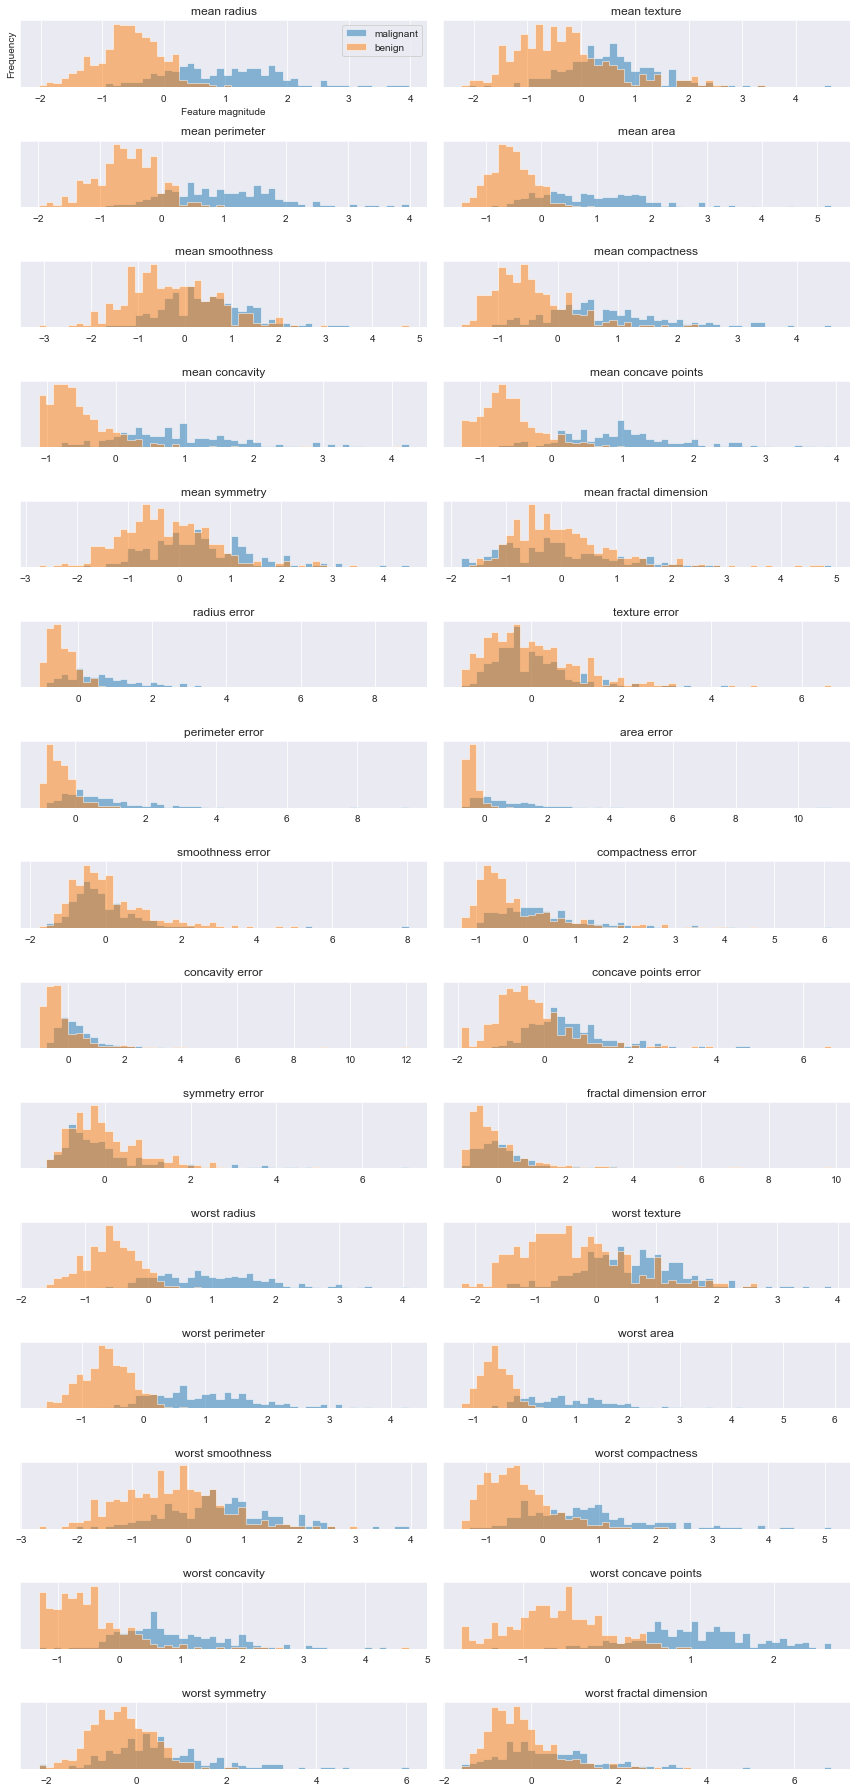

In [6]:
# take a look at the data where OR will be applied
# plotting scaled data
fig1, ax1 = plt.subplots(15, 2, figsize=(12,25))
ax = ax1.ravel()
for i in range(30):
    _, bins = np.histogram(X_scaled[:, i], bins=50)
    ax[i].hist(m_scaled[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].hist(b_scaled[:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['malignant', 'benign'], loc='best')
fig1.tight_layout()
fig1.savefig(datasavedir + '/' + 'data_overview' + '.png')

In [7]:
# set up the latent space, order reduction using PCA
req_ric = 0.99
pca = PCA(req_ric)
pca.fit(X_scaled)
print('Number of components needed for retaining ', req_ric, ' RIC: ', pca.n_components_)

X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
X_pca_plot = pd.DataFrame(X_pca)
X_pca_plot['truth'] = cancer.target
X_pca_0 = X_pca_plot[X_pca_plot['truth']==0]
X_pca_1 = X_pca_plot[X_pca_plot['truth']==1]

Number of components needed for retaining  0.99  RIC:  17
Original shape: (569, 30)
Reduced shape: (569, 17)


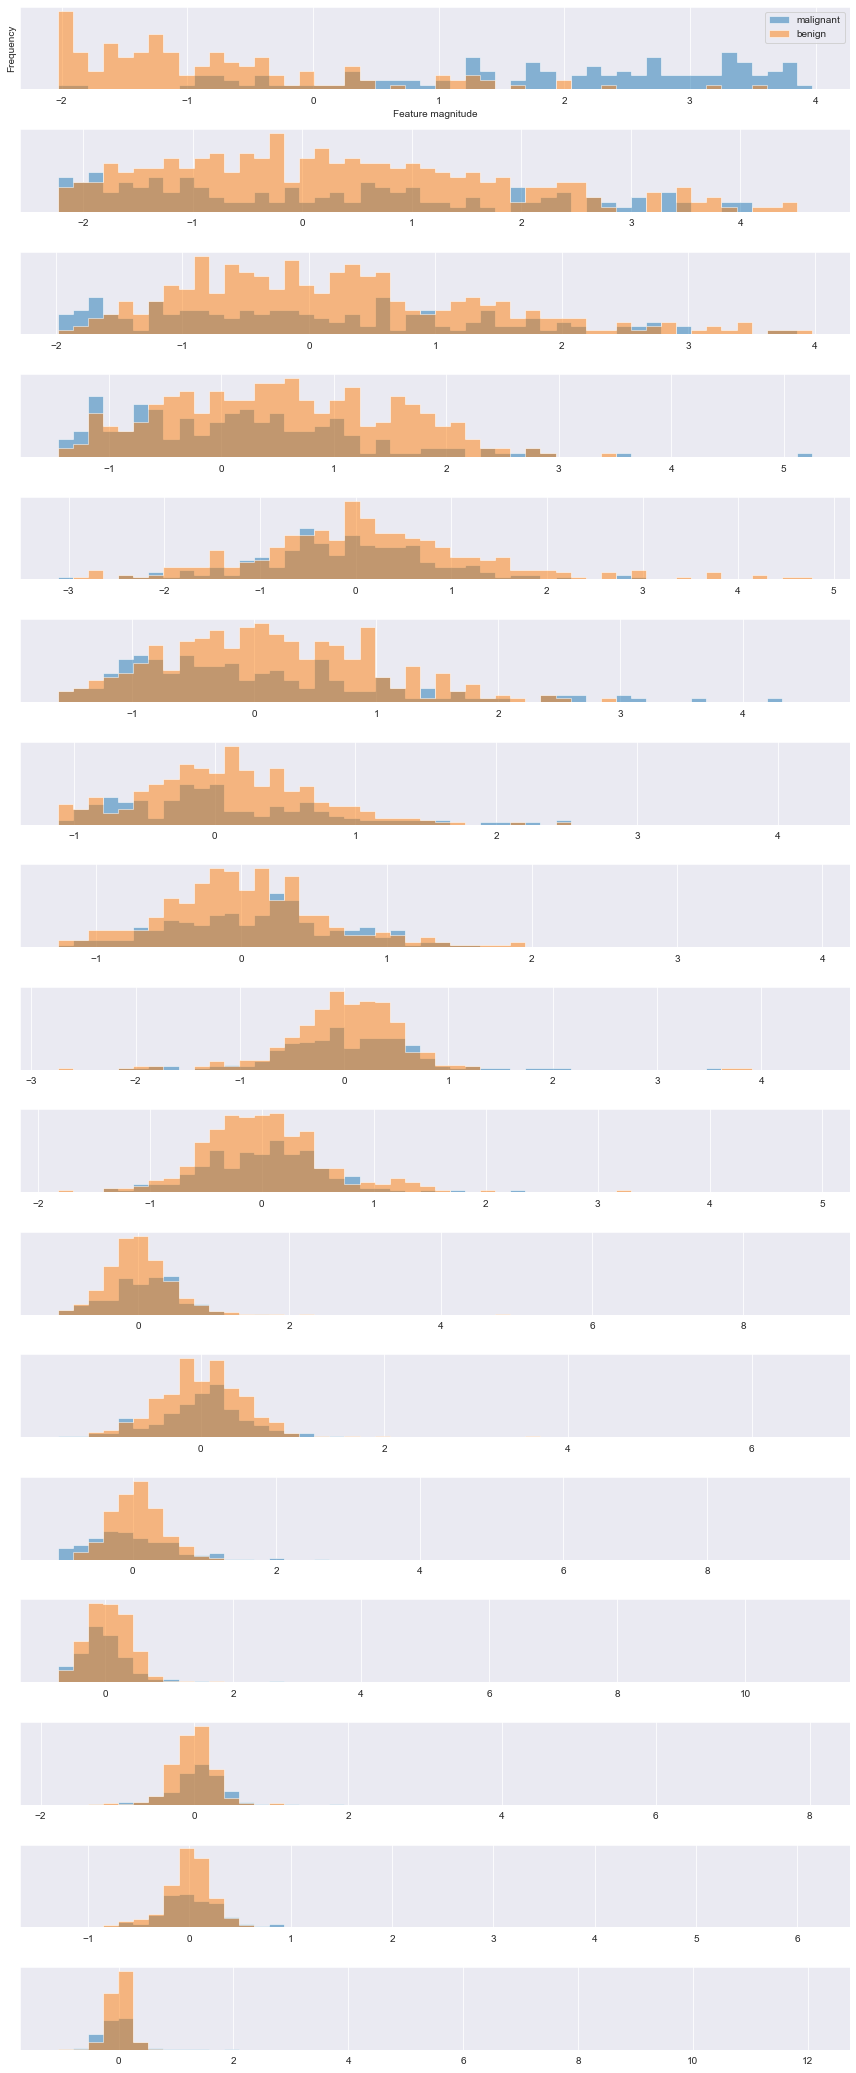

In [8]:
# plotting latent space data
# plotting scaled data
fig2, ax2 = plt.subplots(pca.n_components_, 1, figsize=(12,1.7*pca.n_components_))
ax = ax2.ravel()
for i in range(pca.n_components_):
    # use original bins
    _, bins = np.histogram(X_scaled[:, i], bins=50)
    ax[i].hist(X_pca_0.iloc[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].hist(X_pca_1.iloc[:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['malignant', 'benign'], loc='best')
fig2.tight_layout()


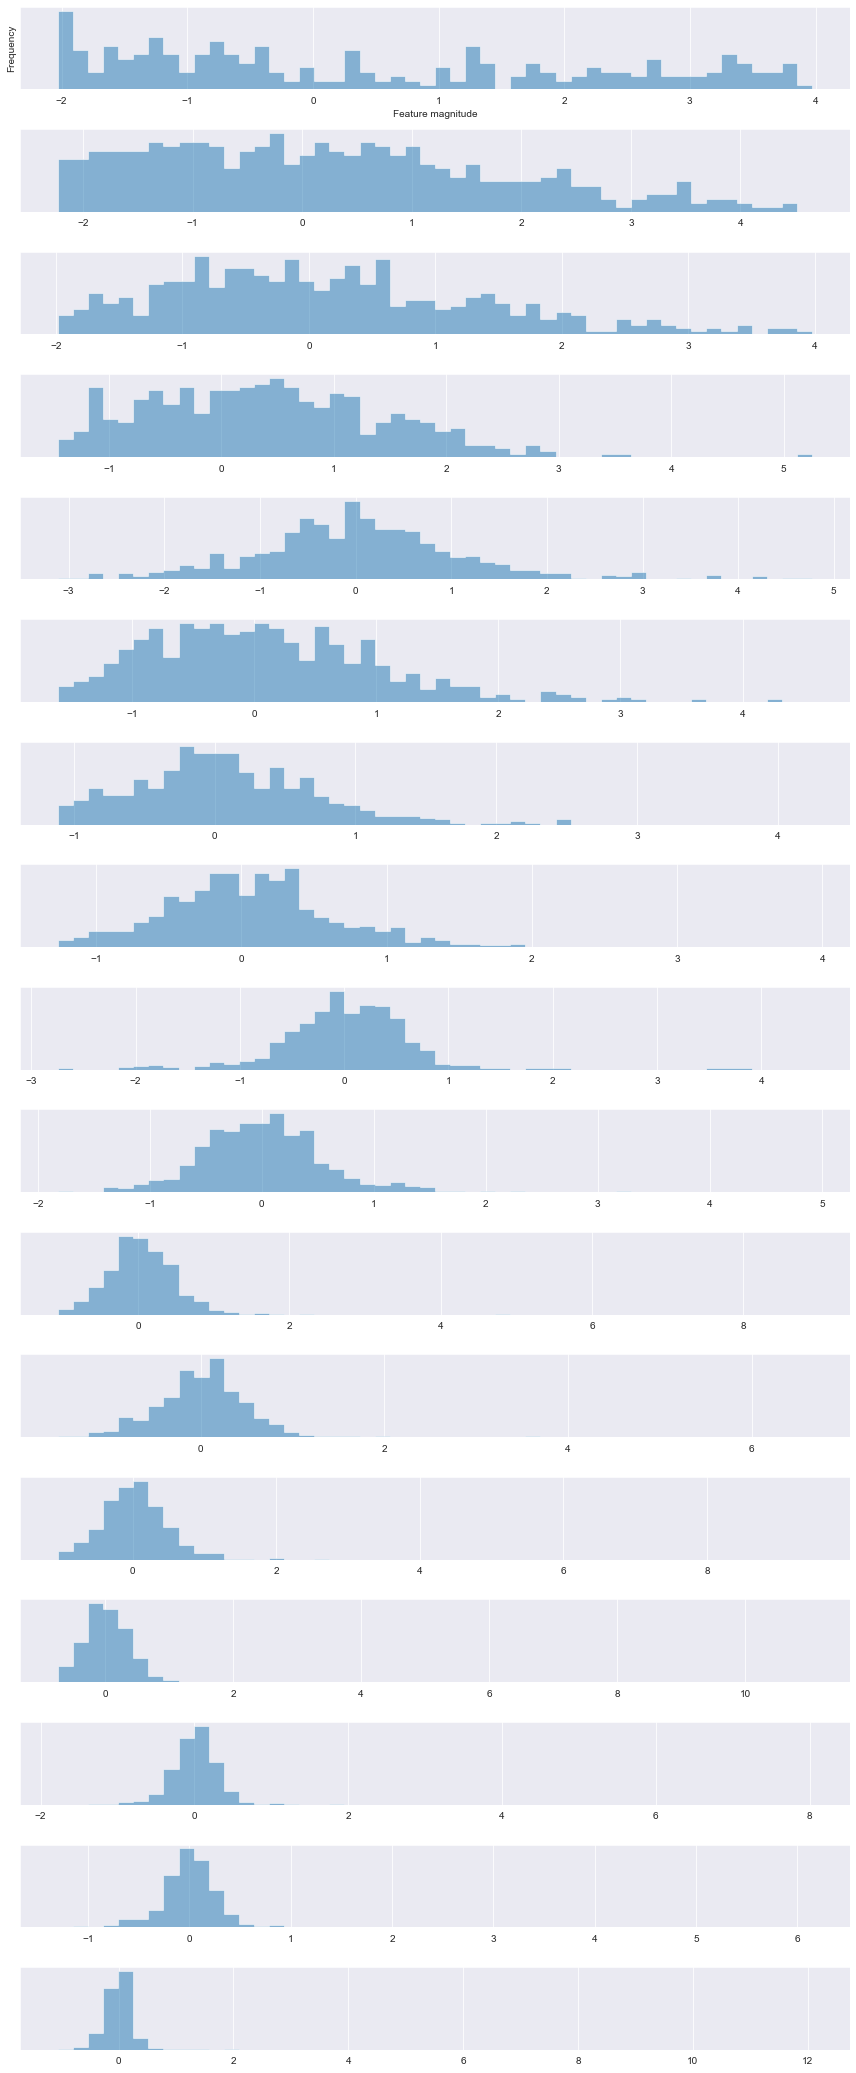

In [9]:
# plotting latent space data without separating by m or b
# plotting scaled data
fig3, ax3 = plt.subplots(pca.n_components_, 1, figsize=(12,1.7*pca.n_components_))
ax = ax3.ravel()
for i in range(pca.n_components_):
    # use original bins
    _, bins = np.histogram(X_scaled[:, i], bins=50)
    ax[i].hist(X_pca[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig3.tight_layout()
fig3.savefig(datasavedir + '/' + 'pca_components' + '.png')

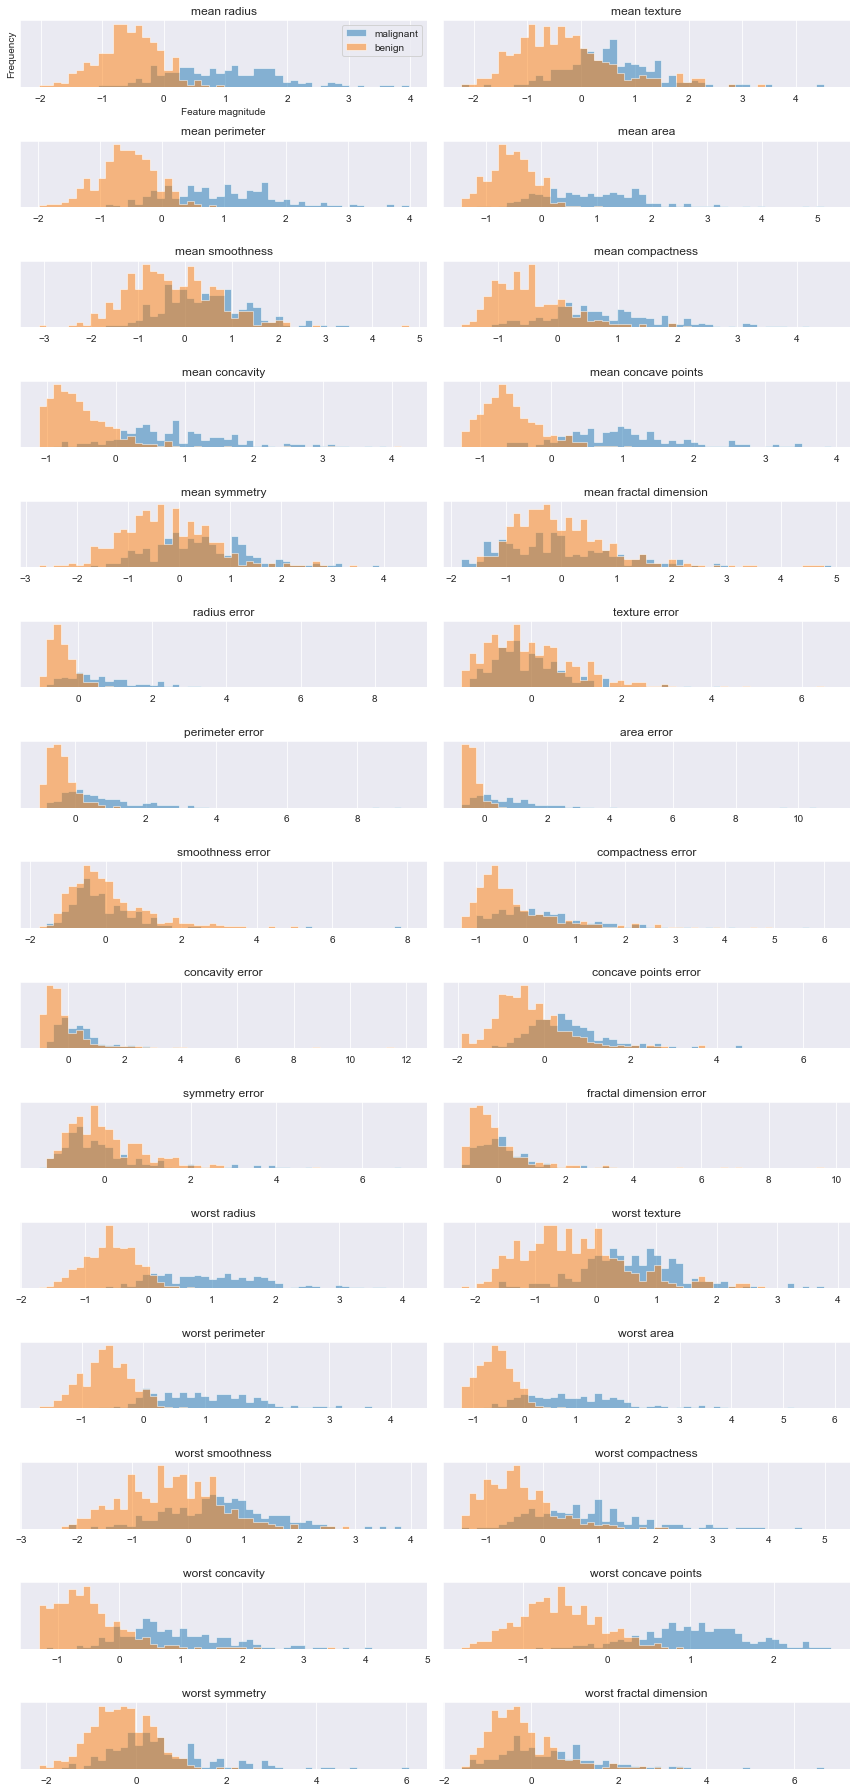

In [10]:
# generating inverse mapping data to compare to original distributions
approx_data = pca.inverse_transform(X_pca)

# plotting
m_scaled_aprx = approx_data[cancer.target == 0]
b_scaled_aprx = approx_data[cancer.target == 1]

# plotting scaled data
fig4, ax4 = plt.subplots(15, 2, figsize=(12,25))
ax = ax4.ravel()
for i in range(30):
    _, bins = np.histogram(X_scaled[:, i], bins=50)
    ax[i].hist(m_scaled_aprx[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].hist(b_scaled_aprx[:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['malignant', 'benign'], loc='best')
fig4.tight_layout()

In [11]:
# calculating the statistical distance between distributions -
# helper functions for calculation of statistical distances

# set up an empirical probability mass/density function as a probability array
def epdf(samp, n=22, density=True):
    if density is True:
        h, e = np.histogram(samp, bins=n, density=density)
        p = h
    else:
        h, e = np.histogram(samp, bins=n, density=density)
        p = h / sum(h)
    return e, p

# enforce properties of probability arrays needed to calculate KL and JS metrics
def support_intersection(p, q):
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

# separate tuple into two arrays
def get_probs(list_of_tuples):
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

# condition data arrays and use scipy JS distance function
def compute_js_dist(p, q):
    """Take as input p and q as epdfs with the same edge values
    # check for and discard inconsistent data based on zeros"""
    temp = support_intersection(p,q)
    pn, qn = get_probs(temp)
    return jensenshannon(pn, qn)

# condition data arrays and use scipy KL divergence function - via entropy
def compute_kl_dist(p, q):
    temp = support_intersection(p,q)
    pn, qn = get_probs(temp)
    return st.entropy(pn, qn)

In [12]:
# calculating the statistical distance between distributions - prep data

# prep data
m_true = m_scaled
m_aprx = m_scaled_aprx
b_true = b_scaled
b_aprx = b_scaled_aprx
data_full= X_scaled
# initialize arrays to hold probability arrays
# ecdf objects for ecdf
m_t_epdf = []
m_a_epdf = []
m_t_ecdf = []
m_a_ecdf = []
b_t_epdf = []
b_a_epdf = []
b_t_ecdf = []
b_a_ecdf = []
epdf_bins = []
# build up probability arrays
# # structure histogram bins from full dataset of samples
# _, bins = np.histogram(data_full[:, i], bins=50)
# full_data_epdf_structure = bins
# malignant case
for i in range(0,m_true.shape[1]):
    _, bins = np.histogram(data_full[:, i], bins=50)
    epdf_bins.append(bins)
    m_t_ecdf.append(ECDF(m_true[:,i]))
    m_a_ecdf.append(ECDF(m_aprx[:,i]))
    _, t_probs = epdf(m_true[:,i],n=bins)
    m_t_epdf.append(t_probs)
    _, a_probs = epdf(m_aprx[:,i],n=bins)
    m_a_epdf.append(a_probs)
# benign case
for i in range(0,b_true.shape[1]):
    _, bins = np.histogram(data_full[:, i], bins=50)
    b_t_ecdf.append(ECDF(b_true[:,i]))
    b_a_ecdf.append(ECDF(b_aprx[:,i]))
    _, t_probs = epdf(b_true[:,i],n=bins)
    b_t_epdf.append(t_probs)
    _, a_probs = epdf(b_aprx[:,i],n=bins)
    b_a_epdf.append(a_probs)

In [13]:
# calculating the statistical distance between distributions - calculate metrics

# initialize arrays for storage
ks_pval = []
ks_metr = []
js_dist = []
kl_divr = []
# maligant case
for i in range(0,len(m_t_ecdf)):
    ks_m, ks_p = st.ks_2samp(m_true[:,i],m_aprx[:,i])
    ks_pval.append(ks_p)
    ks_metr.append(ks_m)
    js_d = compute_js_dist(m_t_epdf[i],m_a_epdf[i])
    js_dist.append(js_d)
    kl_d = compute_kl_dist(m_t_epdf[i],m_a_epdf[i])
    kl_divr.append(kl_d)
# benign case
ksb_pval = []
ksb_metr = []
jsb_dist = []
klb_divr = []
for i in range(0,len(b_t_ecdf)):
    ks_m, ks_p = st.ks_2samp(b_true[:,i],b_aprx[:,i])
    ksb_pval.append(ks_p)
    ksb_metr.append(ks_m)
    js_d = compute_js_dist(b_t_epdf[i],b_a_epdf[i])
    jsb_dist.append(js_d)
    kl_d = compute_kl_dist(b_t_epdf[i],b_a_epdf[i])
    klb_divr.append(kl_d)

Text(0.5, 1.0, 'Benign statistical distances with RIC=0.99')

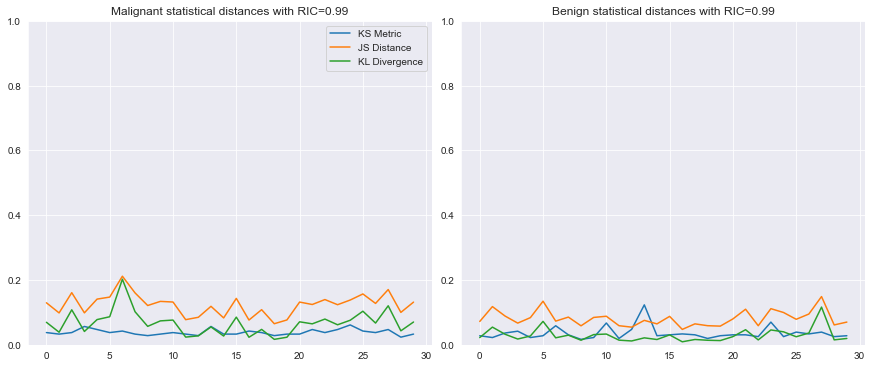

In [14]:
# plot the distance metrics
fig5, ax5 = plt.subplots(1,2,layout='constrained',figsize=(12,5))
ax = ax5.ravel()
ax[0].plot(range(0,len(m_t_ecdf)),ks_metr, label='KS Metric')
ax[0].plot(range(0,len(m_t_ecdf)),js_dist, label='JS Distance')
ax[0].plot(range(0,len(m_t_ecdf)),kl_divr, label='KL Divergence')
ax[0].set_ylim([0,1])
ax[0].legend()
ax[0].set_title('Malignant statistical distances with RIC='+str(req_ric))
ax[1].plot(range(0,len(b_t_ecdf)),ksb_metr, label='KS Metric')
ax[1].plot(range(0,len(b_t_ecdf)),jsb_dist, label='JS Distance')
ax[1].plot(range(0,len(b_t_ecdf)),klb_divr, label='KL Divergence')
ax[1].set_ylim([0,1])
ax[1].set_title('Benign statistical distances with RIC='+str(req_ric))

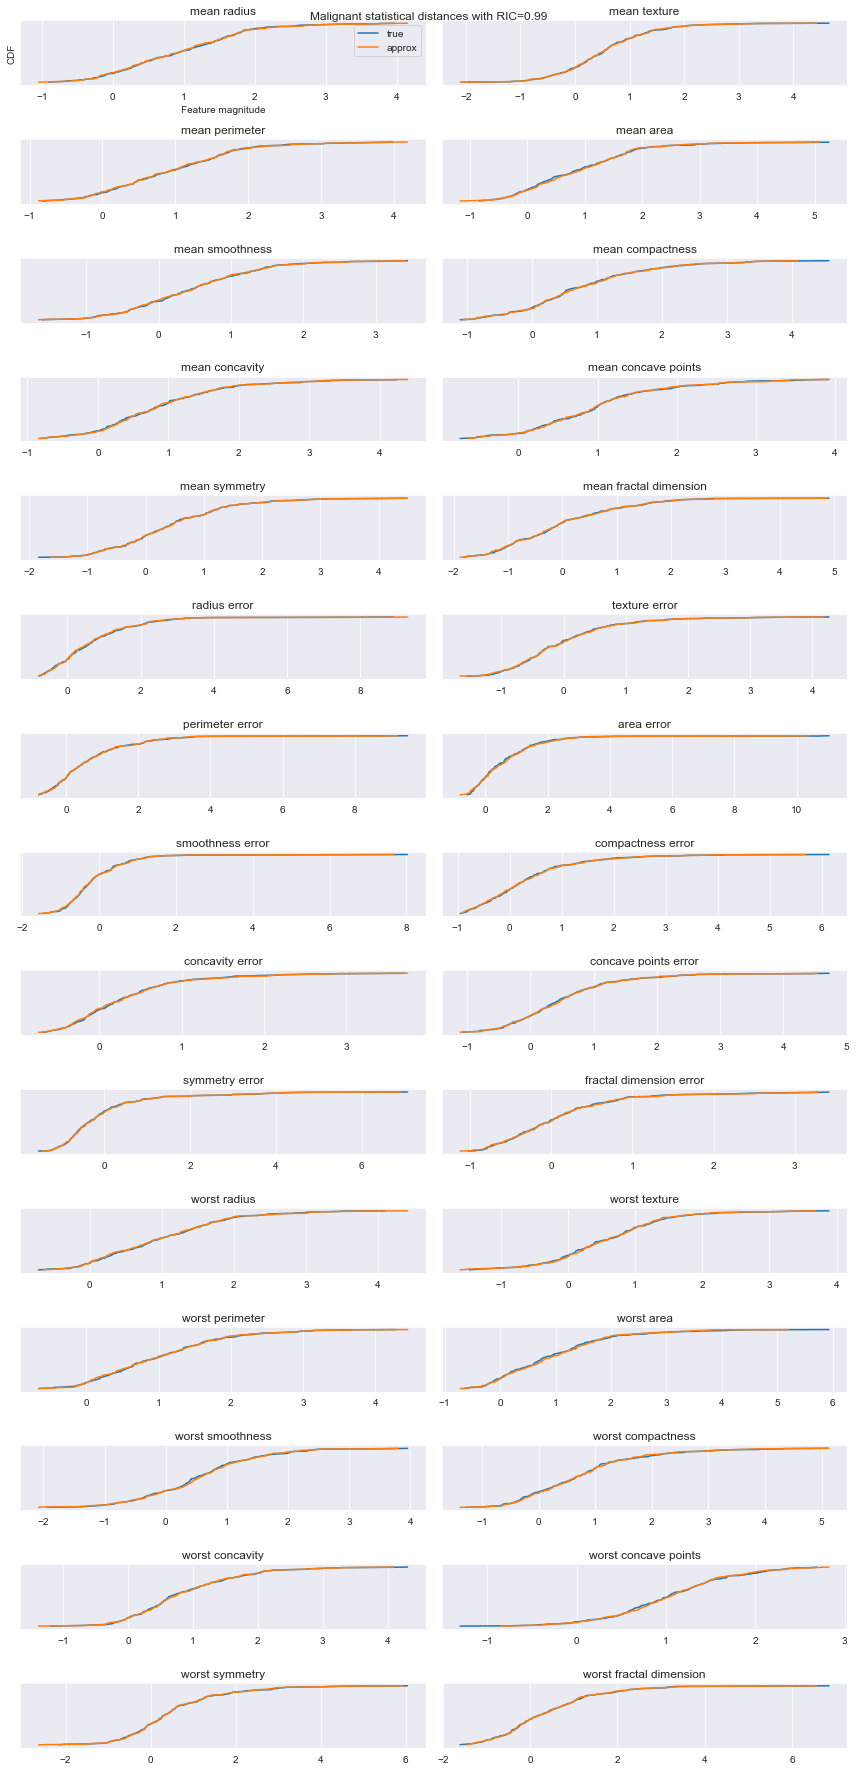

In [15]:
# plot ecdf comparisons on the same subplot axes
# plotting scaled data
fig6, ax6 = plt.subplots(15, 2, figsize=(12,25))
ax = ax6.ravel()
for i in range(30):
    ax[i].plot(m_t_ecdf[i].x, m_t_ecdf[i].y)
    ax[i].plot(m_a_ecdf[i].x, m_a_ecdf[i].y)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig6.suptitle('Malignant statistical distances with RIC='+str(req_ric))
fig6.tight_layout()

Feature  0  compared to  0 stat: 1.000, pval: 0.000
Feature  0  compared to  1 stat: 0.107, pval: 0.122
Feature  0  compared to  2 stat: 0.995, pval: 0.000
Feature  0  compared to  3 stat: 0.990, pval: 0.000
Feature  0  compared to  4 stat: -0.116, pval: 0.092
Feature  0  compared to  5 stat: 0.169, pval: 0.014
Feature  0  compared to  6 stat: 0.483, pval: 0.000
Feature  0  compared to  7 stat: 0.676, pval: 0.000
Feature  0  compared to  8 stat: -0.076, pval: 0.268
Feature  0  compared to  9 stat: -0.389, pval: 0.000
Feature  0  compared to  10 stat: 0.639, pval: 0.000
Feature  0  compared to  11 stat: 0.047, pval: 0.497
Feature  0  compared to  12 stat: 0.625, pval: 0.000
Feature  0  compared to  13 stat: 0.692, pval: 0.000
Feature  0  compared to  14 stat: 0.028, pval: 0.685
Feature  0  compared to  15 stat: 0.078, pval: 0.257
Feature  0  compared to  16 stat: 0.198, pval: 0.004
Feature  0  compared to  17 stat: 0.235, pval: 0.001
Feature  0  compared to  18 stat: 0.034, pval: 0.625


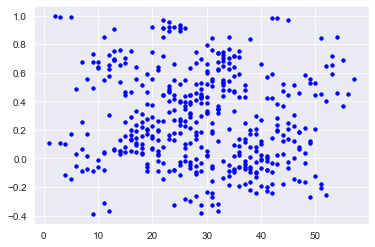

In [16]:
# calculate correlations between data features' sample sets

# malignant
fig7, ax7 = plt.subplots(1,1)
for i in range(0, m_true.shape[1]):
    for j in range(0, m_true.shape[1]):
        corr_test = pearsonr(m_true[:,i],m_true[:,j])
        print('Feature ', i, ' compared to ', j, 'stat: %.3f, pval: %.3f' % (corr_test[0], corr_test[1]))
        if i != j:
            plt.scatter(i+j,corr_test[0],marker='.',c='b')

# Intermission summary
Here, we have established the ability to reduce the dimensionality using linear OR (PCA) purely in the sample space. This is initially promising for using structured representations of the data. In addition, we have established a baseline for the correlation between the distributions, and set up the basic elements for tests of statistical consistency between the distributions.

In [17]:
# structuring data prior to finding latent space

# true data with different structure options
epdf_struct = epdf_bins
# malignant distributions
m_true_samples = m_true
m_true_epdf = m_t_epdf
m_true_ecdf = m_t_ecdf

# benign distributions
b_true_samples = b_true
b_true_epdf = b_t_epdf
b_true_ecdf = b_t_ecdf

# putting data structure options into data array for PCA
# malignant
m_s_epdf = np.array(m_true_epdf).T

# benign
b_s_epdf = np.array(b_true_epdf).T

In [18]:
# run PCA to check OR performance
# set up the latent space, order reduction using PCA (nonparametric)
# malignant
req_ric_m = 0.99
pca_m = PCA(req_ric)
pca_m.fit(m_s_epdf)
print('Malignant number of components needed for retaining ', req_ric_m, ' RIC: ', pca_m.n_components_)
# benign
req_ric_b = 0.99
pca_b = PCA(req_ric)
pca_b.fit(b_s_epdf)
print('Benign number of components needed for retaining ', req_ric_b, ' RIC: ', pca_b.n_components_)
# combined

Malignant number of components needed for retaining  0.99  RIC:  20
Benign number of components needed for retaining  0.99  RIC:  11


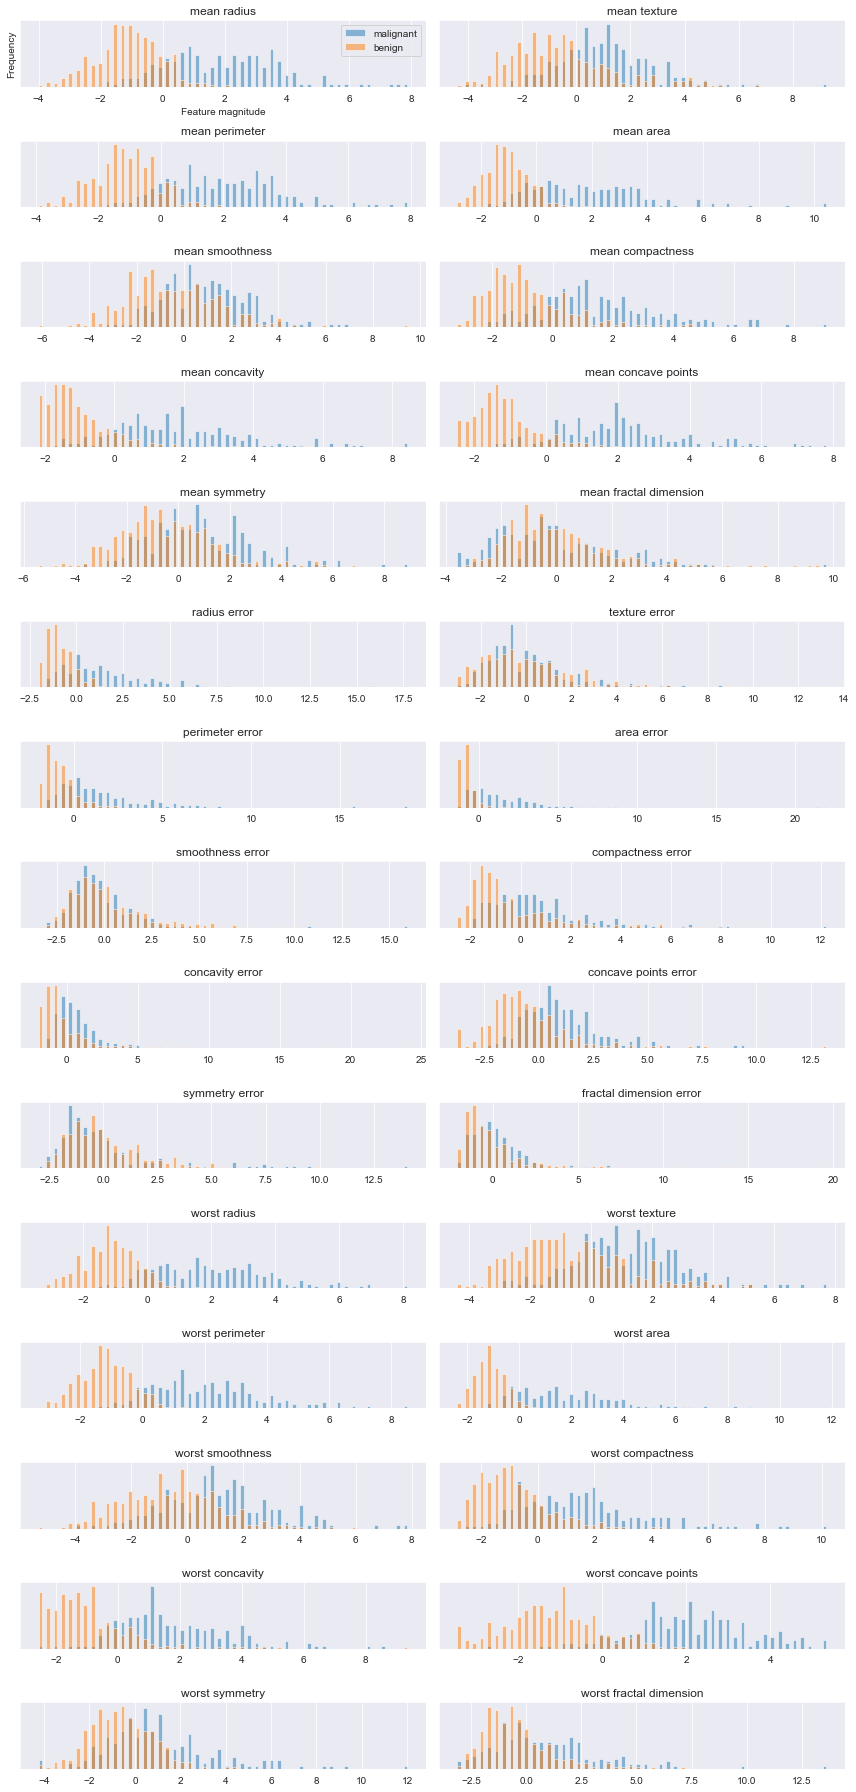

In [19]:
# plotting scaled structured data before pca approx
fig8, ax8 = plt.subplots(15, 2, figsize=(12,25))
ax = ax8.ravel()
for i in range(30):
    center = epdf_struct[i][:-1] + epdf_struct[i][1:]
    width = (epdf_struct[i][1]-epdf_struct[i][0])
    ax[i].bar(center, m_s_epdf[:, i], alpha=0.5,width=width)
    ax[i].bar(center, b_s_epdf[:,i], alpha=0.5, width=width)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['malignant', 'benign'], loc='best')
fig8.tight_layout()
fig8.savefig(datasavedir + '/' + 'histogram_structuring_before_pca' + '.png')

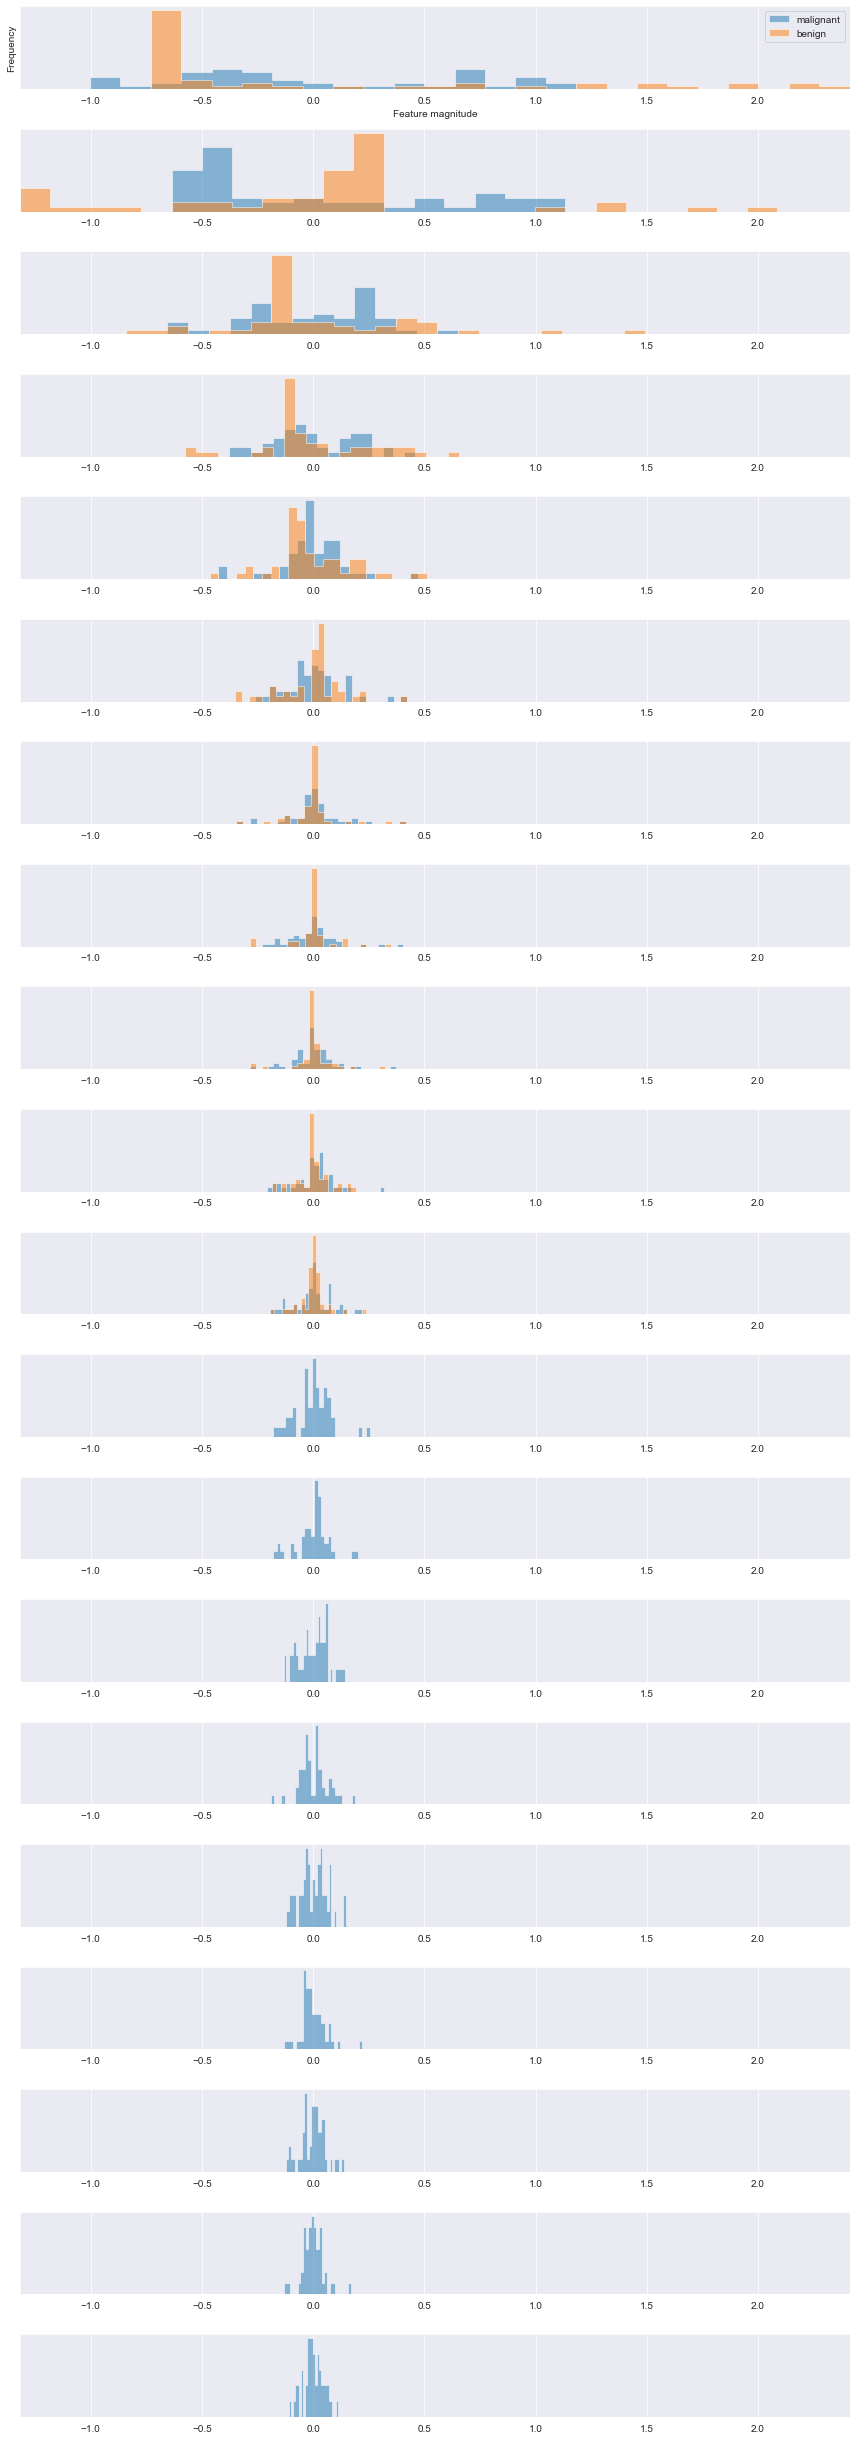

In [23]:
# get individual latent spaces
# maligant
m_s_lat = pca_m.transform(m_s_epdf)

# benign
b_s_lat = pca_b.transform(b_s_epdf)

# plot individual latent spaces
# largest latent dimension
num_lat = max([pca_m.n_components_,pca_b.n_components_])
min_lat = min([pca_m.n_components_,pca_b.n_components_])
# combined latent data
com_lat = np.concatenate((m_s_lat[:,:min_lat],b_s_lat[:,:min_lat]), axis=0)

fig11, ax11 = plt.subplots(num_lat, 1, figsize=(12,1.7*num_lat))
ax = ax11.ravel()
bin_min = 0
bin_max = 0
for i in range(num_lat):
    if (i < min_lat):
        _, bins = np.histogram(com_lat[:, i], bins=25)
    elif (pca_m.n_components_ > pca_b.n_components_):
        _, bins = np.histogram(m_s_lat[:, i], bins=25)
    else:
        _, bins = np.histogram(b_s_lat[:, i], bins=25)
    if (i < pca_m.n_components_):
        ax[i].hist(m_s_lat[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    if (i < pca_b.n_components_):
        ax[i].hist(b_s_lat[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_yticks(())
    if (min(bins) <= bin_min):
        bin_min = min(bins)
    if (max(bins) >= bin_max):
        bin_max = max(bins)
for i in range(num_lat):
    ax[i].set_xlim([bin_min, bin_max])
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['malignant', 'benign'], loc='best')
fig11.tight_layout()
fig11.savefig(datasavedir + '/' + 'structured_data_pca_components' + '.png')

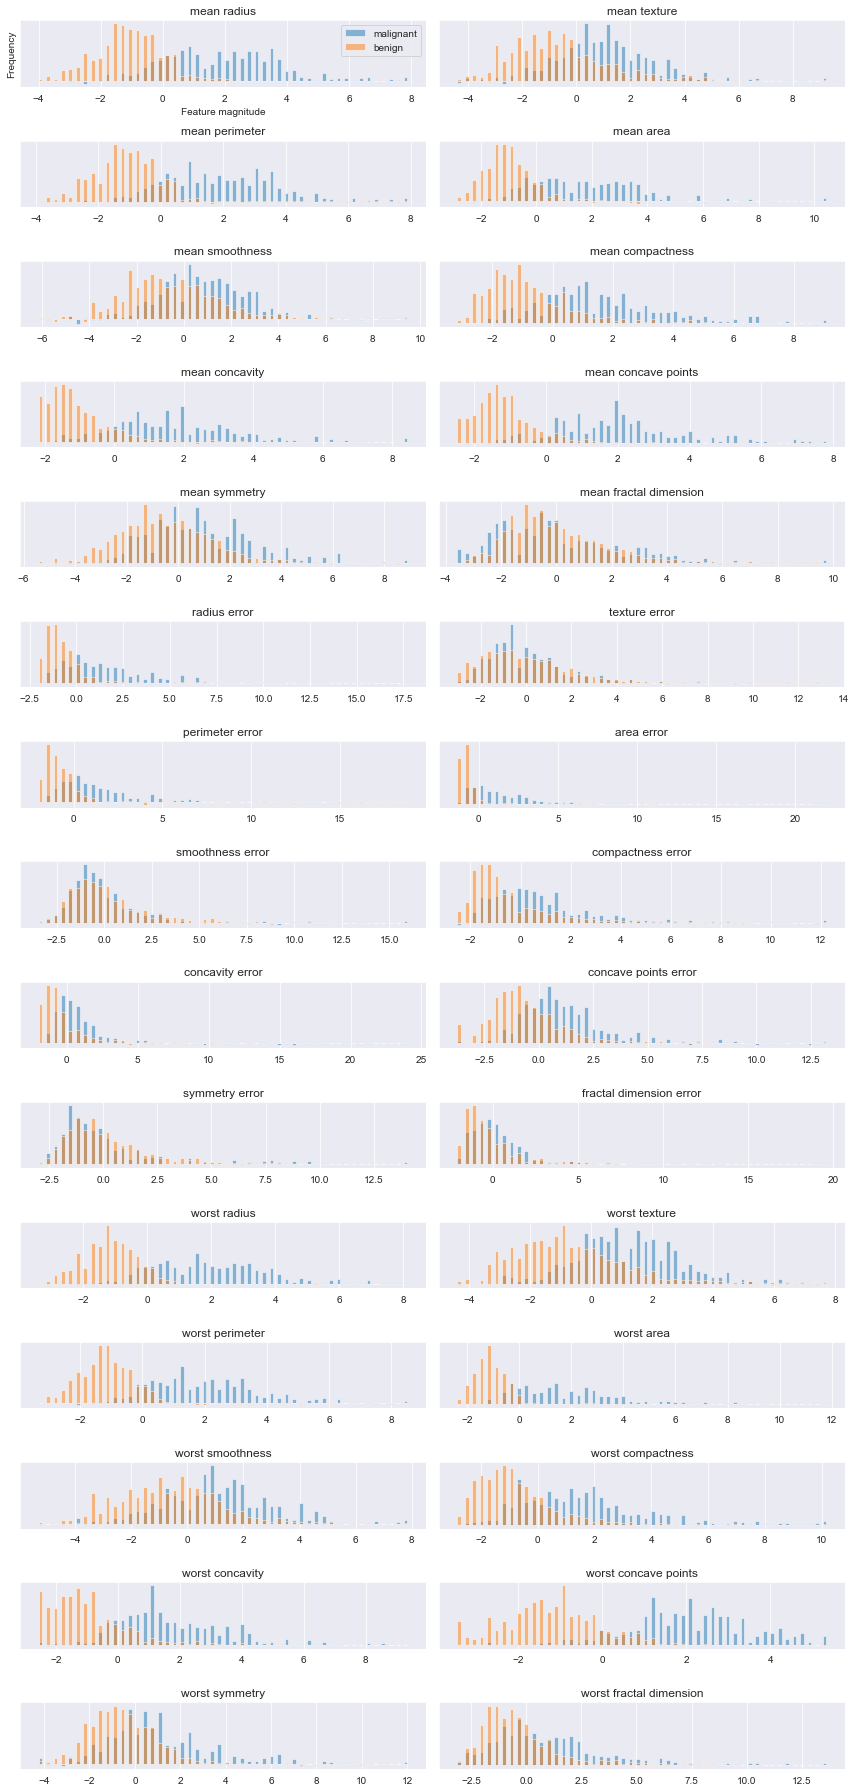

In [21]:
# plot pca approximated structured data
# inverse transform
# malignant
m_s_apx = pca_m.inverse_transform(m_s_lat)

# benign
b_s_apx = pca_b.inverse_transform(b_s_lat)

# plotting
fig12, ax12 = plt.subplots(15, 2, figsize=(12,25))
ax = ax12.ravel()
for i in range(30):
    center = epdf_struct[i][:-1] + epdf_struct[i][1:]
    width = (epdf_struct[i][1]-epdf_struct[i][0])
    ax[i].bar(center, m_s_apx[:, i], alpha=0.5,width=width)
    ax[i].bar(center, b_s_apx[:,i], alpha=0.5, width=width)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['malignant', 'benign'], loc='best')
fig12.tight_layout()
fig12.savefig(datasavedir + '/' + 'histogram_structuring_after_pca' + '.png')

# Summary
With the structuring process, the OR succeeds in finding a better reduction than with only samples